In [14]:
import theano
import theano.tensor as T
import numpy as np
import string
import matplotlib.pyplot as plt
from nltk import pos_tag, word_tokenize
from sklearn.utils import shuffle

In [15]:
def remove_punctuation(s):
    return s.translate(str.maketrans('', '', string.punctuation))

In [16]:
def get_robert_frost():
    word2idx = {'START':0, 'END':1}
    current_idx = 2
    sentences = []
    for line in open("../data/hmm/robert_frost.txt"):
        line = line.strip()
        if line:
            tokens = remove_punctuation(line.lower()).split()
            sentence=[]
            for t in tokens:
                if t not in word2idx:
                    word2idx[t] = current_idx
                    current_idx += 1
                sentence.append(word2idx[t])
            sentences.append(sentence)
    return sentences, word2idx 

In [17]:
def init_weight(Mi, Mo):
    return np.random.randn(Mi, Mo) / np.sqrt(Mi + Mo)

In [18]:
class SimpleRNN:
    def __init__(self, D, M, V):
        self.D = D  # dimensionality of word embedding
        self.M = M  # hidden layer size
        self.V = V  # vocabulary size
        
    def fit(self, X, learning_rate=10e-1, mu=0.99, reg=1.0, activation=T.tanh, epochs=500, show_fig=False):
        
        N = len(X)
        D = self.D
        M = self.M
        V = self.V
        
        # initialize weights
        We = init_weight(V, D)
        Wx = init_weight(D, M)
        Wh = init_weight(M, M)
        bh = np.zeros(M)
        h0 = np.zeros(M)
        Wo = init_weight(M, V)
        bo = np.zeros(V)
        
        W_xz = init_weight(D, M)
        W_hz = init_weight(M, M)
        bz = np.zeros(M)
        
        ################################################
        ###  Prediction through forward propagation  ###
        ################################################
        
        thX, thY, py_x, prediction = self.set_forward(We, Wx, Wh, Wo, bh, h0, bo, W_xz, W_hz, bz, activation)
        
        lr = T.scalar('learning_rate')
            
        ############################################
        ###  Define Cross Entropy and Optimizer  ###
        ############################################
        
        # Symbolic expression of the cross entropy
        # Note, here utilizing matrix indexing to calculate the cross entropy
        cost = -T.mean(T.log(py_x[T.arange(thY.shape[0]), thY]))
        
        # Symbolic expression of the gradient descent
        grads = T.grad(cost, self.params)
        
        # Initialize momentum for all shared parameters
        dparams = [theano.shared(p.get_value()*0) for p in self.params]
        
        # Define rules for updating gradients and momentum
        updates = [
            (p, p + mu*dp - lr*g) for p, dp, g in zip(self.params, dparams, grads)
        ] + [
            (dp, mu*dp - lr*g) for dp, g in zip(dparams, grads)
        ]
        
        self.train_op = theano.function(
            inputs=[thX, thY, lr],
            outputs=[cost, prediction, py_x],
            updates=updates,
        )
        
        ################################################
        ###  Start Training through Backpropagation  ###
        ################################################
        
        costs = []
        
        # Calculate the total number of words in all sentences
        n_total = sum((len(sentence) + 1) for sentence in X)
        
        for i in range(epochs):
            X = shuffle(X)
            n_correct = 0
            n_total = 0
            cost = 0
            for j in range(N):
                # Using stochastic gradient descent
                if np.random.random() < 0.1:
                    input_sequence = [0] + X[j]
                    output_sequence = X[j] + [1]
                else:
                    input_sequence = [0] + X[j][:-1]
                    output_sequence = X[j]
                n_total += len(output_sequence) 
                
                c, p, py_x_ = self.train_op(input_sequence, output_sequence, learning_rate)
                cost += c
                for pj, xj in zip(p, output_sequence):
                    if pj == xj:
                        n_correct += 1
                        
            if i % 20 == 0:
                print("i:", i, "learning rate:", learning_rate, "cost:", cost, "correct rate:", (float(n_correct)/ n_total))
            
            # half the learning rate every 500 epochs
            if (i + 1) % 500 == 0:
                learning_rate /= 2
            costs.append(cost)
        
        if show_fig:
            plt.plot(costs)
            plt.show()
            
   
    def set_forward(self, We, Wx, Wh, Wo, bh, h0, bo, W_xz, W_hz, bz, activation):
        
        self.f = activation
        
        # Define all shared parameters that would be updated during the training
        self.We = theano.shared(We)
        self.Wx = theano.shared(Wx)
        self.Wh = theano.shared(Wh)
        self.Wo = theano.shared(Wo)
        self.bh = theano.shared(bh)
        self.bo = theano.shared(bo)
        self.h0 = theano.shared(h0)
        
        self.W_xz = theano.shared(W_xz)
        self.W_hz = theano.shared(W_hz)
        self.bz = theano.shared(bz)
        
        # Collect all the parameters to make it easy to do gradient descent
        self.params = [self.We, self.Wx, self.Wh, self.Wo, self.bh, self.h0, self.bo, self.W_xz, self.W_hz, self.bz]
        
        # a sequence of indices
        thX = T.ivector('X')
        
        # Get the word embeddings indexed by the index sequence, i.e., thX
        # Ei has shape T x D. Ei can also be think of as a sequence of T timesteps 
        # with D features per timestep
        Ei = self.We[thX] 
        
        thY = T.ivector('Y')
        
        # This is how we define simple recurrent unit, I left it here for comparison
        #
        # def recurrence(x_t, h_t1):
        # h_t = self.f(x_t.dot(self.Wx) + h_t1.dot(self.Wh) + self.bh)
        # y_t = T.nnet.softmax(h_t.dot(self.Wo) + self.bo)
        # return h_t, y_t
            
        # Rated Recurrent Unit
        def recurrence(x_t, h_t1):
            z_t = T.nnet.sigmoid(x_t.dot(self.W_xz) + h_t1.dot(self.W_hz) + self.bz)
            h_hat_t = self.f(x_t.dot(self.Wx) + h_t1.dot(self.Wh) + self.bh)
            h_t = (1 - z_t) * h_t1 + z_t * h_hat_t
            y_t = T.nnet.softmax(h_t.dot(self.Wo) + self.bo)
            return h_t, y_t

        [h, y], _ = theano.scan(
            fn=recurrence,
            sequences=Ei,
            outputs_info=[self.h0, None],
            n_steps=Ei.shape[0],
        )

        py_x = y[:, 0, :]
        
        prediction = T.argmax(py_x, axis=1)
        self.prediction_op = theano.function(
            inputs=[thX], 
            outputs=[py_x, prediction],
            allow_input_downcast=True,
        )
        
        return thX, thY, py_x, prediction
    
    
    def save(self, filename):
        np.savez(filename, *[p.get_value() for p in self.params])

    def predict(self, X):
        py_x, _ = self.prediction_op(X)
        return py_x


i: 0 learning rate: 0.0001 cost: 10984.2751822 correct rate: 0.04897096655641308
i: 20 learning rate: 0.0001 cost: 8600.78732045 correct rate: 0.053882287924841114
i: 40 learning rate: 0.0001 cost: 8086.49118423 correct rate: 0.05770823745973309
i: 60 learning rate: 0.0001 cost: 7420.95419312 correct rate: 0.062080382599098684
i: 80 learning rate: 0.0001 cost: 6761.98356388 correct rate: 0.07663964627855564
i: 100 learning rate: 0.0001 cost: 6174.31246704 correct rate: 0.11643330876934414
i: 120 learning rate: 0.0001 cost: 5704.8362512 correct rate: 0.17016961651917403
i: 140 learning rate: 0.0001 cost: 5392.24284528 correct rate: 0.19793871353639458
i: 160 learning rate: 0.0001 cost: 5079.96838567 correct rate: 0.23521827224166514
i: 180 learning rate: 0.0001 cost: 4849.10416392 correct rate: 0.26300285372364907
i: 200 learning rate: 0.0001 cost: 4647.98528944 correct rate: 0.28311759845772516
i: 220 learning rate: 0.0001 cost: 4483.31414403 correct rate: 0.30518941837957414
i: 240 le

i: 1980 learning rate: 1.25e-05 cost: 1636.77005368 correct rate: 0.7542022595756407


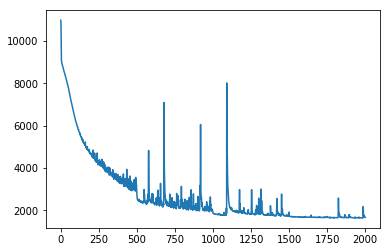

In [20]:
sentences, word2idx = get_robert_frost()
V = len(word2idx)
rnn = SimpleRNN(50, 50, V)
rnn.fit(sentences, learning_rate=10e-5, show_fig=True, activation=T.nnet.relu, epochs=2000) 
#vlr stands for variable learning rate
rnn.save("generating_poetry_rrnn_D50_M50_epochs2000_relu_vlr.npz")


In [21]:
def load(filename, activation):
    npz = np.load(filename)
    We = npz['arr_0']
    Wx = npz['arr_1']
    Wh = npz['arr_2']
    Wo = npz['arr_3']
    bh = npz['arr_4']
    h0 = npz['arr_5']
    bo = npz['arr_6']
    W_xz = npz['arr_7']
    W_hz = npz['arr_8']
    bz = npz['arr_9']
        
    V, D = We.shape
    _, M = Wx.shape
    rnn = SimpleRNN(D, M, V)
    rnn.set_forward(We, Wx, Wh, Wo, bh, h0, bo, W_xz, W_hz, bz, activation)
    return rnn

In [36]:
rnn = load("generating_poetry_rrnn_D50_M50_epochs2000_relu_vlr.npz", T.nnet.relu)
sentences, word2idx = get_robert_frost()
idx2word = {v:k for k, v in word2idx.items()}
V = len(word2idx)

# generate 4 lines at a time
n_lines = 0

# get the first word according to the probabilty distribution
#   X = [np.random.choice(V, p=pi)]
#   print(idx2word[X[0]])
X = [0]

while n_lines < 4:
    
    # py_x is the predicted distribution over words 
    # in vocabulary given word index sequence X, starting with [0]
    py_x = rnn.predict(X)
#     print("py_x shape:", py_x.shape)
#     print("py_x:", py_x)
    
    py_x = py_x[-1].flatten()
    
    # Generate a value from V based on distribution of py_x
    P = [np.random.choice(V, p=py_x)]
#     X += [P]
#     print("P shape:", len(P))
#     print("P:", P)
    # append to the sequence
    X = np.concatenate([X, P]) 
#     print("X", X)
    # just grab the most recent prediction
#     P = P[-1]
    P = P[0]
    if  P > 1:
        word = idx2word[P]
        print(word + " ", end="")
    elif P == 1:
        # end token
        n_lines += 1
        X = [0]
        print()

always the witchs motto anyway 
i have outwalked the furthest city light 
one level nearer heaven overhead 
with all once on a day and said up 
